Our goal is to create a $k$-nearest neighbors classifier from scratch using the underlying mathematical principles, and compare it to the KNN classifier included within the scikit-learn library.

We'll start by creating a dataset of random clustered points via NumPy, and some of it off into a testing set.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

# Number of new points to generate
n = 15
# Dimension of points
m = 2

# Seed for random generation
np.random.seed(42)

num_red = np.random.randint(30, 81)
num_blue = np.random.randint(30, 81)
num_green = np.random.randint(30, 81)
num_yellow = np.random.randint(30, 81)

points = {'red': np.random.normal(loc=[2.5, 2.5], scale=1.75, size=(num_red, m)),       # Generate a cluster around (2.5, 2.5) using a normal distribution.
          'blue': np.random.normal(loc=[2.5, 7.5], scale=1.75, size=(num_blue, m)),
          'green': np.random.normal(loc=[7.5, 2.5], scale=1.75, size=(num_green, m)),
          'yellow': np.random.normal(loc=[7.5, 7.5], scale=1.75, size=(num_yellow, m))}

# Combine all points into one array
all_points = np.concatenate([points[key] for key in points])

# Create labels for points
labels = np.concatenate([np.full(len(points[key]), key) for key in points])

# Split data training and testing
X_train, X_test, y_train, y_test = train_test_split(all_points, labels, test_size=0.2, random_state=42)

# Reorganize points dictionary based on the split
train_points = {}
test_points = {}

for color in np.unique(labels):
    train_points[color] = X_train[y_train == color]
    test_points[color] = X_test[y_test == color]

print("Training points:")
for key, value in train_points.items():
    print(f'{key}: {len(value)} points')

print('\nTesting points:')
for key, value in test_points.items():
    print(f'{key}: {len(value)} points')

Training points:
blue: 48 points
green: 35 points
red: 52 points
yellow: 58 points

Testing points:
blue: 10 points
green: 9 points
red: 16 points
yellow: 14 points


Now, we will work with the standard metric space $\mathbb{R}^2$, and as such, Euclidean distance is sufficient for our classifier (though one can, of course, take other metrics on $\mathbb{R}^2$, like the Manhattan or Chebyshev, or the Minkowski as a generalization of all these).

For any points $p$ and $q$ in $\mathbb{R}^n$, the distance between them $d(p, q)$ is given by
$$d(p, q) = \sqrt{\sum_{i = 1}^n (q_i - p_i)^2}.$$
Note that for our purposes, we will only be summing up to $n = 2$.

We begin creation of the model.

In [2]:
from collections import Counter

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, points):
        self.points = points

    def predict(self, new_points):
        predictions = []
        for new_point in new_points:
            distances = []
            for color in self.points:
                for point in self.points[color]:
                    dist = np.sqrt(np.sum((point - new_point) ** 2))         # Calculate Euclidean distance.
                    distances.append([dist, color])                          # Store distance and color in list of tuples.
            
            # Sort distances and take first k colors.
            k_nearest_colors = sorted(distances)[:self.k]
            
            # Pull the most common color from list of k nearest colors.
            result = Counter(tuple[1] for tuple in k_nearest_colors).most_common(1)[0][0]       # As k_nearest_colors is sorted, this ensures that the result is always the color of the nearest point, in the event of a tie (assuming k is even).
            predictions.append(result)
        return predictions

Let's find out which $k$ value results in the highest accuracy.

In [3]:
accuracies = []
best_accuracy = 0

for k in range(1, 21):
    knn = KNN(k)
    knn.fit({key: X_train[y_train == key] for key in np.unique(y_train)})
    predictions = knn.predict(X_test)
    accuracy = np.mean(predictions == y_test)
    print(f'Accuracy for k={k}: {accuracy}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f'\nBest k-value: {best_k} with accuracy: {best_accuracy}')

Accuracy for k=1: 0.7346938775510204
Accuracy for k=2: 0.7346938775510204
Accuracy for k=3: 0.7346938775510204
Accuracy for k=4: 0.8163265306122449
Accuracy for k=5: 0.7755102040816326
Accuracy for k=6: 0.8367346938775511
Accuracy for k=7: 0.8163265306122449
Accuracy for k=8: 0.8163265306122449
Accuracy for k=9: 0.7755102040816326
Accuracy for k=10: 0.7755102040816326
Accuracy for k=11: 0.7755102040816326
Accuracy for k=12: 0.8367346938775511
Accuracy for k=13: 0.8163265306122449
Accuracy for k=14: 0.8571428571428571
Accuracy for k=15: 0.8163265306122449
Accuracy for k=16: 0.8571428571428571
Accuracy for k=17: 0.8367346938775511
Accuracy for k=18: 0.8571428571428571
Accuracy for k=19: 0.8571428571428571
Accuracy for k=20: 0.8571428571428571

Best k-value: 14 with accuracy: 0.8571428571428571


It seems $k = 14$ is the best choice, so let's continue on with this selection.

In [4]:
knn = KNN(k=14)
knn.fit(points)
predictions = knn.predict(X_test)

predictions

['red',
 'red',
 'green',
 'yellow',
 'yellow',
 'yellow',
 'yellow',
 'green',
 'red',
 'blue',
 'red',
 'yellow',
 'green',
 'yellow',
 'blue',
 'red',
 'blue',
 'red',
 'red',
 'red',
 'green',
 'red',
 'blue',
 'red',
 'yellow',
 'green',
 'blue',
 'blue',
 'yellow',
 'green',
 'blue',
 'yellow',
 'red',
 'red',
 'red',
 'green',
 'blue',
 'yellow',
 'green',
 'yellow',
 'blue',
 'blue',
 'blue',
 'red',
 'yellow',
 'red',
 'green',
 'red',
 'yellow']

## Comparison with scikit-learn's KNN classifier

As before, we test the accuracy for different $k$-values. We also compare it to our values above.

In [20]:
from tabulate import tabulate
from sklearn.neighbors import KNeighborsClassifier

# Our model
accuracies = []
best_accuracy = 0

for k in range(1, 21):
    knn = KNN(k)
    knn.fit({key: X_train[y_train == key] for key in np.unique(y_train)})
    predictions = knn.predict(X_test)
    accuracy = np.mean(predictions == y_test)
    accuracies.append([k, accuracy])

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k


# scikit-learn model
accuracies_sk = []
best_accuracy_sk = 0

for k in range(1, 21):
    knn_sk = KNeighborsClassifier(n_neighbors=k)
    knn_sk.fit(X_train, y_train)
    accuracy_sk = knn_sk.score(X_test, y_test)
    accuracies_sk.append([k, accuracy_sk])

    if accuracy_sk > best_accuracy_sk:
        best_accuracy_sk = accuracy_sk
        best_k_sk = k

# Combine the two lists
combined_accuracies = []
for acc, acc_sk in zip(accuracies, accuracies_sk):
    combined_accuracies.append([acc[0], acc[1], acc_sk[1]])

# Print results in a table with three columns
print(tabulate(combined_accuracies, headers=['k', 'Our Accuracy', "scikit-learn's Accuracy"], tablefmt='pretty'))
print(f'\nBest k-value for our implementation: {best_k} with accuracy: {best_accuracy}')
print(f"\nBest k-value for scikit-learn's implementation: {best_k_sk} with accuracy: {best_accuracy_sk}")


+----+--------------------+-------------------------+
| k  |    Our Accuracy    | scikit-learn's Accuracy |
+----+--------------------+-------------------------+
| 1  | 0.7346938775510204 |   0.7346938775510204    |
| 2  | 0.7346938775510204 |   0.7142857142857143    |
| 3  | 0.7346938775510204 |   0.7551020408163265    |
| 4  | 0.8163265306122449 |   0.7755102040816326    |
| 5  | 0.7755102040816326 |   0.7755102040816326    |
| 6  | 0.8367346938775511 |   0.7755102040816326    |
| 7  | 0.8163265306122449 |   0.8163265306122449    |
| 8  | 0.8163265306122449 |   0.7755102040816326    |
| 9  | 0.7755102040816326 |   0.7755102040816326    |
| 10 | 0.7755102040816326 |   0.7755102040816326    |
| 11 | 0.7755102040816326 |   0.7755102040816326    |
| 12 | 0.8367346938775511 |   0.7959183673469388    |
| 13 | 0.8163265306122449 |   0.8163265306122449    |
| 14 | 0.8571428571428571 |   0.7959183673469388    |
| 15 | 0.8163265306122449 |   0.8163265306122449    |
| 16 | 0.8571428571428571 | 

Curiously, it seems our model has higher accuracy at almost all $k$-values. Note however, that we have not tried this model anywhere other than this specific dataset, so this may not be the case in general. Regardless, we proceed by taking the most accurate $k$-value.

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn_sk = KNeighborsClassifier(n_neighbors=19)
knn_sk.fit(X_train, y_train)
predictions_sk = knn_sk.predict(X_test)

predictions_sk

array(['red', 'red', 'green', 'yellow', 'yellow', 'yellow', 'yellow',
       'green', 'red', 'blue', 'red', 'yellow', 'green', 'yellow', 'blue',
       'red', 'blue', 'red', 'red', 'red', 'green', 'red', 'blue', 'red',
       'yellow', 'green', 'blue', 'blue', 'yellow', 'green', 'blue',
       'yellow', 'red', 'red', 'red', 'green', 'blue', 'yellow', 'green',
       'yellow', 'blue', 'blue', 'blue', 'red', 'yellow', 'red', 'green',
       'red', 'yellow'], dtype='<U6')

## Visualizations

Finally, let us produce quick visualizations of our model and scikit-learn's model side by side, to see the predictions they've made.

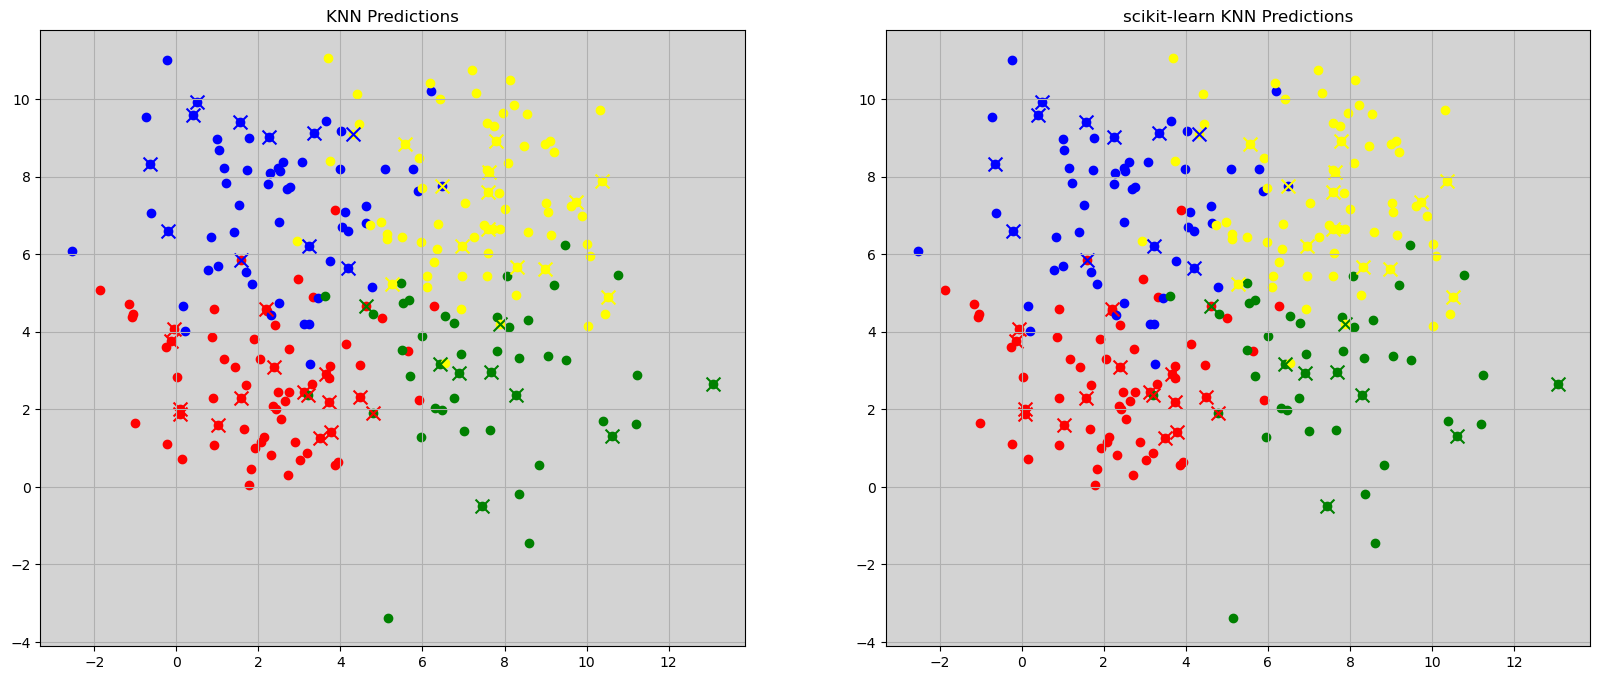

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Our model
ax[0].set_title('KNN Predictions')

# Plot actual points
for color in points:
    ax[0].scatter(points[color][:, 0], points[color][:, 1], c=color, label=color)

# Plot predicted points
for pred_color, true_color, point in zip(predictions, y_test, X_test):
    ax[0].scatter(point[0], point[1], c=pred_color, marker='x', s=100)

ax[0].set_facecolor('lightgray')
ax[0].grid(True)

# scitkit_learn's model
ax[1].set_title('scikit-learn KNN Predictions')

# Plot actual points
for color in points:
    ax[1].scatter(points[color][:, 0], points[color][:, 1], c=color, label=color)

# Plot predicted points
for pred_color, true_color, point in zip(predictions_sk, y_test, X_test):
    ax[1].scatter(point[0], point[1], c=pred_color, marker='x', s=100)

ax[1].set_facecolor('lightgray')
ax[1].grid(True)

plt.show()


The same predictions! If we play around and change $k$ to 16 for scikit-learn's model to match ours (or indeed, if we change $k$ to any other value), we see the predictions may be different.